# Power spectrum example

This tutorial shows how to make and manipulate a power spectrum of two light curves using Stingray.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

## 1. Create a light curve
There are two ways to make `Lightcurve` objects. We'll show one way here. Check out "Lightcurve/Lightcurve\ tutorial.ipynb" for more examples.

Generate an array of relative timestamps that's 8 seconds long, with dt = 0.03125 s, and make two signals in units of counts. The signal is a sine wave with amplitude = 300 cts/s, frequency = 2 Hz, phase offset = 0 radians, and mean = 1000 cts/s. We then add Poisson noise to the light curve.

In [2]:
dt = 0.03125  # seconds
exposure = 8.  # seconds
times = np.arange(0, exposure, dt)  # seconds

signal = 300 * np.sin(2.*np.pi*times/0.5) + 1000  # counts/s
noisy = np.random.poisson(signal*dt)  # counts

Now let's turn `noisy` into a `Lightcurve` object.

In [3]:
lc = Lightcurve(times, noisy, dt=dt, skip_checks=True)

Here we plot it to see what it looks like.

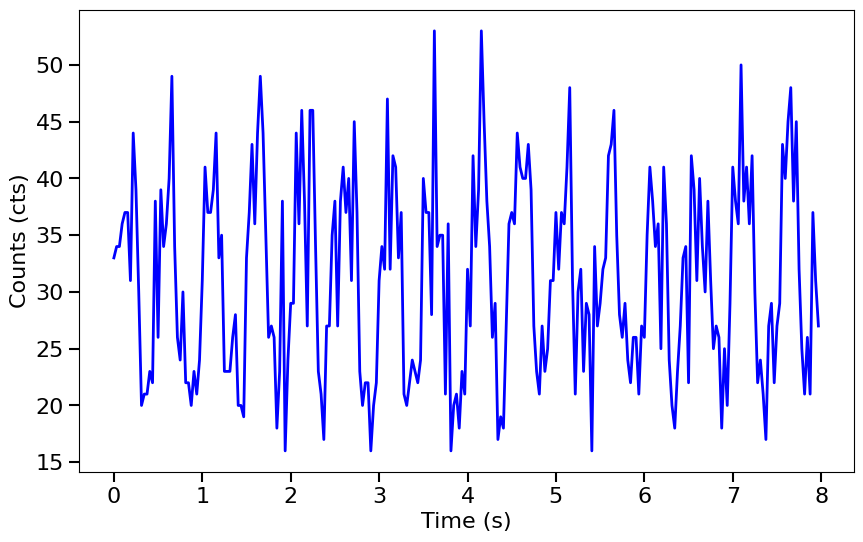

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(lc.time, lc.counts, lw=2, color='blue')
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

## 2. Pass the light curve to the `Powerspectrum` class to create a `Powerspectrum` object.
You can also specify the optional attribute `norm` if you wish to normalize power to squared fractional rms, Leahy, or squared absolute normalization. The default normalization is 'none'.

In [5]:
ps = Powerspectrum.from_lightcurve(lc, norm="leahy")
print(ps)

Note that, in principle, the `Powerspectrum` object could have been initialized directly as

```
ps = Powerspectrum(lc, norm="leahy")
```
However, we recommend using this explicit syntax, for clarity. Equivalently, one can initialize a `Powerspectrum` object:

1. from an `EventList` object as

   ```
   bin_time = 0.1
   ps = Powerspectrum.from_events(events, dt=bin_time, norm="leahy")
   ```
   where the light curve, uniformly binned at 0.1 s, is created internally.

2. from a `numpy` array of times expressed in seconds, as
   ```
   bin_time = 0.1
   ps = Powerspectrum.from_events(times, dt=bin_time, gti=[[t0, t1], [t2, t3], ...], norm="leahy")
   ```
   where the light curve, uniformly binned at 0.1 s, is created internally, and the good time intervals (time interval where the instrument was collecting data nominally) are passed by hand.

3. from an iterable of light curves
   ```
   ps = Powerspectrum.from_lc_iter(lc_iterable, norm="leahy")
   ```
   where `lc_iterable` is any iterable of `Lightcurve` objects (list, tuple, generator, etc.)

Since the negative Fourier frequencies (and their associated powers) are discarded, the number of time bins per segment `n` is twice the length of `freq` and `power`.

In [6]:
print("\nSize of positive Fourier frequencies:", len(ps.freq))
print("Number of data points per segment:", ps.n)


Size of positive Fourier frequencies: 127
Number of data points per segment: 256


# Properties
A `Powerspectrum` object has the following properties :

1. `freq` : Numpy array of mid-bin frequencies that the Fourier transform samples.
2. `power` : Numpy array of the power spectrum.
3. `df` : The frequency resolution.
4. `m` : The number of power spectra averaged together. For a `Powerspectrum` of a single segment, `m=1`.
5. `n` : The number of data points (time bins) in one segment of the light curve.
6. `nphots1` : The total number of photons in the light curve.
7. `norm` : The normalization, one of `leahy` (Leahy et al. 1983), `abs` (absolute rms), `frac` (fractional rms), or `none`


In [7]:
print(ps.freq)
print(ps.power)
print(ps.df)
print(ps.m)
print(ps.n)
print(ps.nphots1)

[ 0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125  1.25
  1.375  1.5    1.625  1.75   1.875  2.     2.125  2.25   2.375  2.5
  2.625  2.75   2.875  3.     3.125  3.25   3.375  3.5    3.625  3.75
  3.875  4.     4.125  4.25   4.375  4.5    4.625  4.75   4.875  5.
  5.125  5.25   5.375  5.5    5.625  5.75   5.875  6.     6.125  6.25
  6.375  6.5    6.625  6.75   6.875  7.     7.125  7.25   7.375  7.5
  7.625  7.75   7.875  8.     8.125  8.25   8.375  8.5    8.625  8.75
  8.875  9.     9.125  9.25   9.375  9.5    9.625  9.75   9.875 10.
 10.125 10.25  10.375 10.5   10.625 10.75  10.875 11.    11.125 11.25
 11.375 11.5   11.625 11.75  11.875 12.    12.125 12.25  12.375 12.5
 12.625 12.75  12.875 13.    13.125 13.25  13.375 13.5   13.625 13.75
 13.875 14.    14.125 14.25  14.375 14.5   14.625 14.75  14.875 15.
 15.125 15.25  15.375 15.5   15.625 15.75  15.875]
[9.75294222e-02 1.37192421e-01 6.62062702e+00 5.42273987e-01
 1.26707856e-01 7.14262683e-02 1.46986106e+00 9.35172244e

We can plot the power as a function of Fourier frequency. Notice how there's a spike at our signal frequency of 2 Hz!

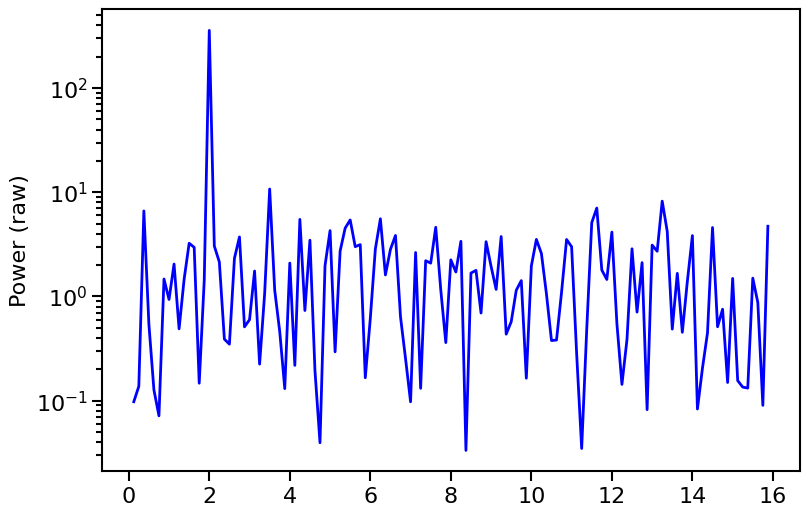

In [8]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6), sharex=True)
ax1.plot(ps.freq, ps.power, lw=2, color='blue')
ax1.set_ylabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

You'll notice that the power spectrum is a bit noisy. This is because we're only using one segment of data. Let's try averaging together power spectra from multiple segments of data.
# Averaged power spectrum example
You could use a long `Lightcurve` and have `AveragedPowerspectrum` chop it into specified segments, or give a list of `Lightcurve`s where each segment of `Lightcurve` is the same length. We'll show the first way here.
## 1. Create a long light curve.
Generate an array of relative timestamps that's 1600 seconds long, and a signal in count units, with the same properties as the previous example. We then add Poisson noise and turn it into a `Lightcurve` object.

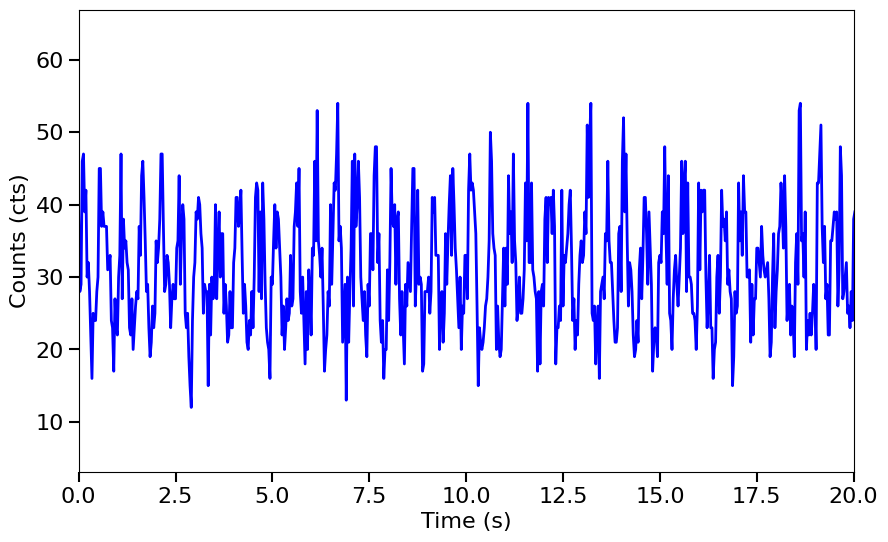

In [9]:
long_dt = 0.03125  # seconds
long_exposure = 1600.  # seconds
long_times = np.arange(0, long_exposure, long_dt)  # seconds

# In count rate units here
long_signal = 300 * np.sin(2.*np.pi*long_times/0.5) + 1000

# Multiply by dt to get count units, then add Poisson noise
long_noisy = np.random.poisson(long_signal*dt)

long_lc = Lightcurve(long_times, long_noisy, dt=long_dt, skip_checks=True)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(long_lc.time, long_lc.counts, lw=2, color='blue')
ax.set_xlim(0,20)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.show()

## 2. Pass the light curve to the `AveragedPowerspectrum` class with a specified `segment_size`.
If the exposure (length) of the light curve cannot be divided by `segment_size` with a remainder of zero, the last incomplete segment is thrown out, to avoid signal artefacts. Here we're using 8 second segments.

In [10]:
avg_ps = AveragedPowerspectrum.from_lightcurve(long_lc, 8., norm="leahy")

200it [00:00, 50515.52it/s]


We can check how many segments were averaged together by printing the `m` attribute.

In [11]:
print("Number of segments: %d" % avg_ps.m)

Number of segments: 200


`AveragedPowerspectrum` has the same properties as `Powerspectrum`, but with `m` $>$1.

Let's plot the averaged power spectrum!

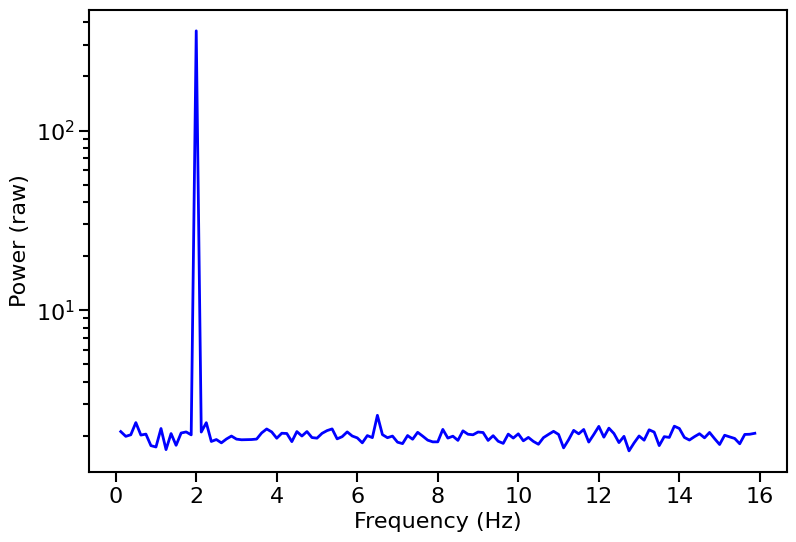

In [12]:
fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(avg_ps.freq, avg_ps.power, lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

Now we'll show examples of all the things you can do with a `Powerspectrum` or `AveragedPowerspectrum` object using built-in stingray methods.

# Normalizating the power spectrum
The three kinds of normalization are:
* `leahy`: Leahy normalization. Makes the Poisson noise level $= 2$. See *Leahy et al. 1983, ApJ, 266, 160L*. 
* `frac`: Fractional rms-squared normalization, also known as rms normalization. Makes the Poisson noise level $= 2 / meanrate$. See *Belloni & Hasinger 1990, A&A, 227, L33*, and *Miyamoto et al. 1992, ApJ, 391, L21.*
* `abs`: Absolute rms-squared normalization, also known as absolute normalization. Makes the Poisson noise level $= 2 \times meanrate$. See *insert citation*.
* `none`: No normalization applied. This is the default.

In [13]:
avg_ps_leahy = AveragedPowerspectrum.from_lightcurve(long_lc, 8, norm='leahy')
avg_ps_frac = AveragedPowerspectrum.from_lightcurve(long_lc, 8., norm='frac')
avg_ps_abs = AveragedPowerspectrum.from_lightcurve(long_lc, 8., norm='abs')

200it [00:00, 56159.93it/s]
200it [00:00, 56752.64it/s]
200it [00:00, 43677.02it/s]


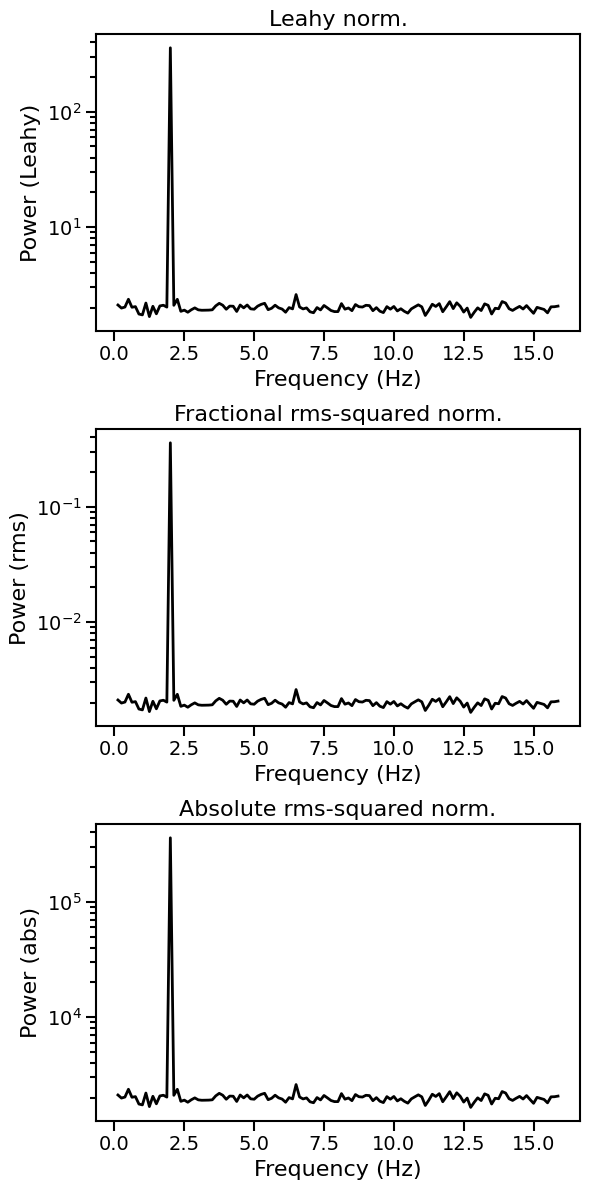

In [14]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(6,12))
ax1.plot(avg_ps_leahy.freq, avg_ps_leahy.power, lw=2, color='black')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (Leahy)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
ax1.set_title("Leahy norm.", fontproperties=font_prop)
    
ax2.plot(avg_ps_frac.freq, avg_ps_frac.power, lw=2, color='black')
ax2.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax2.set_ylabel("Power (rms)", fontproperties=font_prop)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_yscale('log')
ax2.tick_params(which='major', width=1.5, length=7)
ax2.tick_params(which='minor', width=1.5, length=4)
ax2.set_title("Fractional rms-squared norm.", fontproperties=font_prop)

ax3.plot(avg_ps_abs.freq, avg_ps_abs.power, lw=2, color='black')
ax3.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax3.set_ylabel("Power (abs)", fontproperties=font_prop)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_yscale('log')
ax3.tick_params(which='major', width=1.5, length=7)
ax3.tick_params(which='minor', width=1.5, length=4)
ax3.set_title("Absolute rms-squared norm.", fontproperties=font_prop)

for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
    ax2.spines[axis].set_linewidth(1.5)
    ax3.spines[axis].set_linewidth(1.5)
plt.tight_layout()
plt.show()

# Re-binning a power spectrum in frequency
Typically, rebinning is done on an averaged, normalized power spectrum.
## 1. We can linearly re-bin a power spectrum
(although this is not done much in practice)

In [15]:
print("DF before:", avg_ps.df)
# Both of the following ways are allowed syntax:
# lin_rb_ps = Powerspectrum.rebin(avg_ps, 0.25, method='mean')
lin_rb_ps = avg_ps.rebin(0.25, method='mean')
print("DF after:", lin_rb_ps.df)

DF before: 0.125
DF after: 0.25


## 2. And we can logarithmically/geometrically re-bin a power spectrum
In this re-binning, each bin size is 1+f times larger than the previous bin size, where `f` is user-specified and normally in the range 0.01-0.1. The default value is `f=0.01`.

In [16]:
# Both of the following ways are allowed syntax:
# log_rb_ps, log_rb_freq, binning = Powerspectrum.rebin_log(avg_ps, f=0.02)
log_rb_ps = ps.rebin_log(f=0.02)

Like `rebin`, `rebin_log` returns a `Powerspectrum` or `AveragedPowerspectrum` object (depending on the input object):

In [17]:
print(type(lin_rb_ps))

<class 'stingray.powerspectrum.AveragedPowerspectrum'>


# Power spectra of normal-distributed light curves

Starting with Stingray 0.3, we can also get Leahy-normalized power spectra of normally-distributed light curves.
Let us calculate such a light curve by subtracting the noise level and normalizing


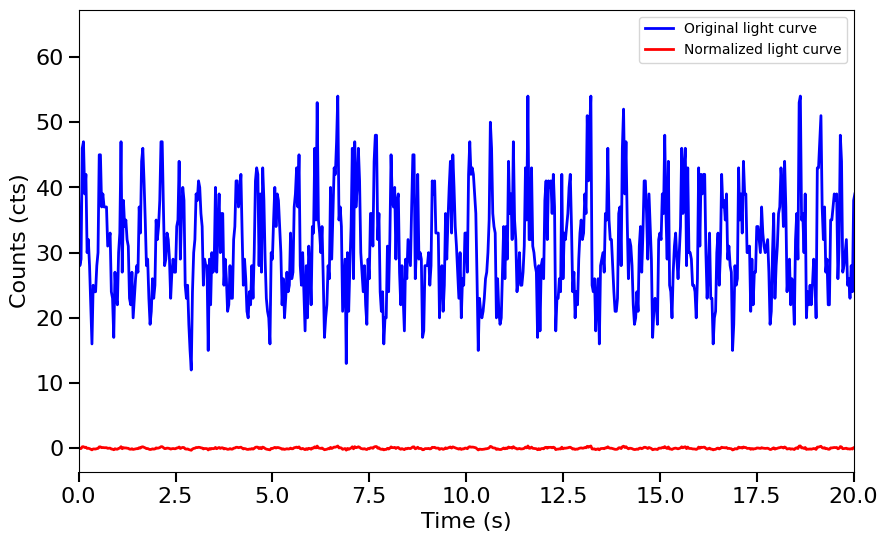

In [18]:
long_norm = (long_noisy - long_noisy.mean()) / long_noisy.max()
err = np.sqrt(long_noisy.mean()) / long_noisy.max()

long_lc_gauss = Lightcurve(long_times, long_norm, err=np.zeros_like(long_norm) + err, dt=long_dt, skip_checks=True, err_dist='gauss')

fig, ax = plt.subplots(1,1,figsize=(10, 6))
ax.plot(long_lc.time, long_lc.counts, lw=2, color='blue', label='Original light curve')
ax.plot(long_lc_gauss.time, long_lc_gauss.counts, lw=2, color='red', label='Normalized light curve')
ax.set_xlim(0,20)
ax.set_xlabel("Time (s)", fontproperties=font_prop)
ax.set_ylabel("Counts (cts)", fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)
plt.legend()
plt.show()

In [19]:
avg_ps_gauss_leahy = AveragedPowerspectrum.from_lightcurve(long_lc_gauss, 8, norm='leahy')
avg_ps_gauss_frac = AveragedPowerspectrum.from_lightcurve(long_lc_gauss, 8., norm='frac')
avg_ps_gauss_abs = AveragedPowerspectrum.from_lightcurve(long_lc_gauss, 8., norm='abs')

200it [00:00, 46520.67it/s]
200it [00:00, 39276.19it/s]
200it [00:00, 43715.71it/s]


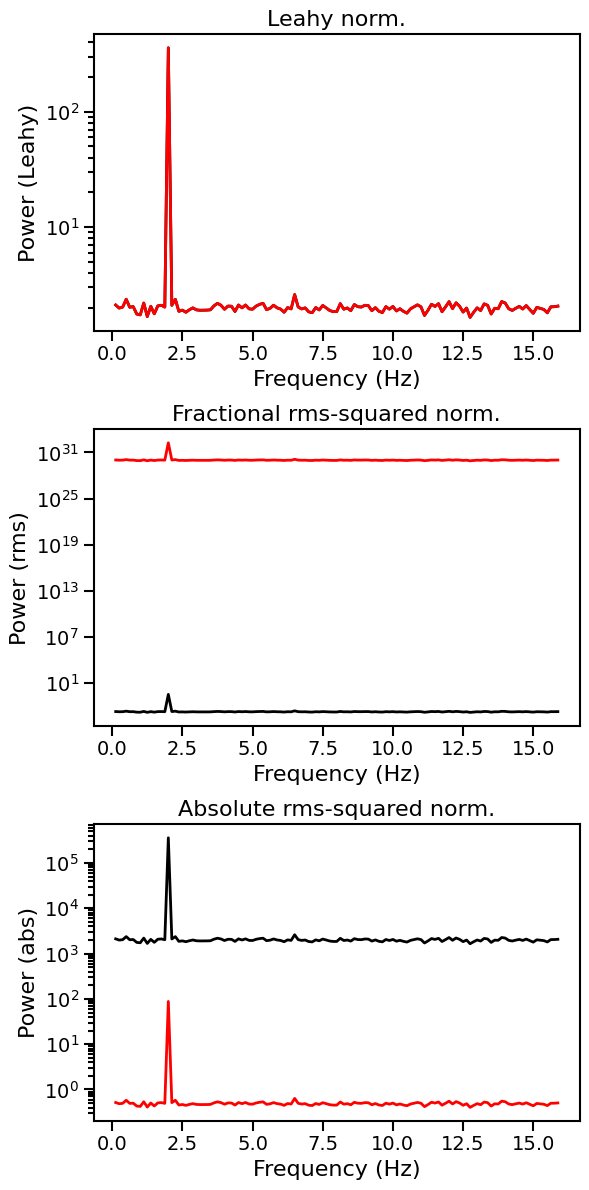

In [20]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(6,12))
ax1.plot(avg_ps_leahy.freq, avg_ps_leahy.power, lw=2, color='black')
ax1.plot(avg_ps_gauss_leahy.freq, avg_ps_gauss_leahy.power, lw=2, color='red', zorder=10)
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (Leahy)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
ax1.set_title("Leahy norm.", fontproperties=font_prop)
  
ax2.plot(avg_ps_frac.freq, avg_ps_frac.power, lw=2, color='black')
ax2.plot(avg_ps_gauss_frac.freq, avg_ps_gauss_frac.power, lw=2, color='red')
ax2.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax2.set_ylabel("Power (rms)", fontproperties=font_prop)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_yscale('log')
ax2.tick_params(which='major', width=1.5, length=7)
ax2.tick_params(which='minor', width=1.5, length=4)
ax2.set_title("Fractional rms-squared norm.", fontproperties=font_prop)

ax3.plot(avg_ps_abs.freq, avg_ps_abs.power, lw=2, color='black')
ax3.plot(avg_ps_gauss_abs.freq, avg_ps_gauss_abs.power, lw=2, color='red')
ax3.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax3.set_ylabel("Power (abs)", fontproperties=font_prop)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_yscale('log')
ax3.tick_params(which='major', width=1.5, length=7)
ax3.tick_params(which='minor', width=1.5, length=4)
ax3.set_title("Absolute rms-squared norm.", fontproperties=font_prop)

for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
    ax2.spines[axis].set_linewidth(1.5)
    ax3.spines[axis].set_linewidth(1.5)

plt.tight_layout()
plt.show()

As expected, the Leahy normalization, being normalized by the variance, yields *exactly* the same result in the Gaussian and the Poisson case, while the fractional rms (that depends on the mean count rate) and the absolute rms (that depend on the variance and the mean count rate) change.